# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
import matplotlib.pyplot as plt
from getData import getData
import pandas as pd
import os

cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [6]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    1572.003960
cluster_1    2350.292663
cluster_2    2374.507270
cluster_3    2186.572278
cluster_4    1572.650655
cluster_5    1767.840650
cluster_6    2719.564564
cluster_7    1553.045964
dtype: float64

### Wind offshore

In [7]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [8]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0       0.000000
cluster_1    4435.420314
cluster_2    4301.655834
cluster_3    3902.391858
cluster_4       0.000000
cluster_5       0.000000
cluster_6    4609.508396
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [10]:
data['PV, operationRateMax'].sum()

cluster_0    1113.216464
cluster_1    1053.579422
cluster_2    1058.005181
cluster_3    1079.872237
cluster_4    1140.407380
cluster_5    1051.848141
cluster_6    1069.843344
cluster_7    1085.697466
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [13]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [14]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.6, 'CO2':201*1e-6/0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [15]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.63},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.63},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [17]:
esM.add(fn.Conversion(esM=esM, name='Electrolyzer', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [18]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [19]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [20]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [21]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [22]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [23]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


### DC cables

In [24]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [25]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [26]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [27]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [28]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [29]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

# 8 Temporal Aggregation

In [30]:
esM.cluster(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(4.4210 sec)



/home/r-beer/.conda/envs/spagat_py36/lib/python3.6/site-packages/tsam/timeseriesaggregation.py:960: UserWarning: Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series
  "Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series")


### Optimization

In [31]:
esM.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.2341 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1875 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.8277 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3437 sec)

Declaring shared potential constraint...
		(0.0015 sec)

Declaring commodity balances...
		(1.0310 sec)

Declaring objective function...
		(0.3281 sec)

Using license file C:\Users\there\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\there\AppD

for StorageModel ...       (4.9676sec)
for TransmissionModel ...  (2.8431sec)
		(9.9039 sec)



# 9. Selected results output

Plot locations (GeoPandas required)

In [32]:
# Import the geopandas package for plotting the locations
import geopandas as gpd

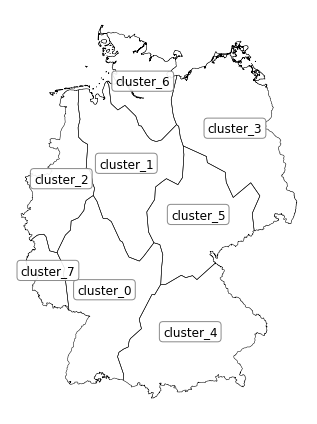

In [33]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

### Sources and Sink

Show optimization summary

In [34]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.264223   
                             commodCosts [1e9 Euro/a]             0.264223   
                             operation   [GW$_{biogas,LHV}$*h/a]   4884.88   
Electricity demand           operation   [GW$_{el}$*h/a]            133963   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.144316   
                             capacity    [GW$_{el}$]              0.693828   
                             operation   [GW$_{el}$*h/a]           3167.33   
                             opexCap     [1e9 Euro/a]             0.144316   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    15855.2   
PV                           TAC         [1e9 Euro/a]              3.09317   
                             capacity    [GW$_{el}$]               41.8612   
                             capexCap    [1e9 Euro/a]              2.54898   
                             invest      [1e9 Euro]                27.2098   
                             operation   [GW$_{el}$*h/a]           38192.5   
                             opexCap     [1e9 Euro/a]             0.544195   
Wind (offshore)              TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             capexCap    [1e9 Euro/a]                  NaN   
                             invest      [1e9 Euro]                    NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Wind (onshore)               TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                     0   
                             capexCap    [1e9 Euro/a]                    0   
                             invest      [1e9 Euro]                      0   
                             operation   [GW$_{el}$*h/a]                 0   
                             opexCap     [1e9 Euro/a]                    0   

                                                                  cluster_1  \
Component                    Property    Unit                                 
Biogas purchase              TAC         [1e9 Euro/a]              0.253751   
                             commodCosts [1e9 Euro/a]              0.253751   
                             operation   [GW$_{biogas,LHV}$*h/a]    4691.28   
Electricity demand           operation   [GW$_{el}$*h/a]              66116   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.0077909   
                             capacity    [GW$_{el}$]              0.0374563   
                             operation   [GW$_{el}$*h/a]            170.988   
                             opexCap     [1e9 Euro/a]             0.0077909   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]     11007.1   
PV                           TAC         [1e9 Euro/a]               1.90997   
                             capacity    [GW$_{el}$]                25.8484   
                             capexCap    [1e9 Euro/a]               1.57394   
                             invest      [1e9 Euro]                 16.8014   
                             operation   [GW$_{el}$*h/a]            26972.9   
                             opexCap     [1e9 Euro/a]              0.336029   
Wind (offshore)              TAC         [1e9 Euro/a]               1.12104   
                             capacity    [GW$_{el}$]                      4   
                             capexCap    [1e9 Euro/a]               0.93704   
                             invest      [1e9 Euro]                     9.2   
                             operation   [GW$_{el}$*h/a]            12696.8   
                             opexCap     [1e9 Euro/a]           

Plot installed capacities

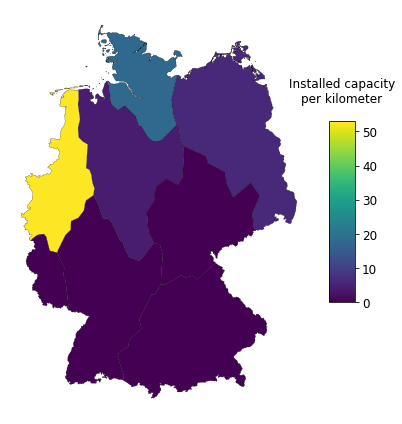

In [35]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (offshore)', locFilePath, 'index', perArea=False)

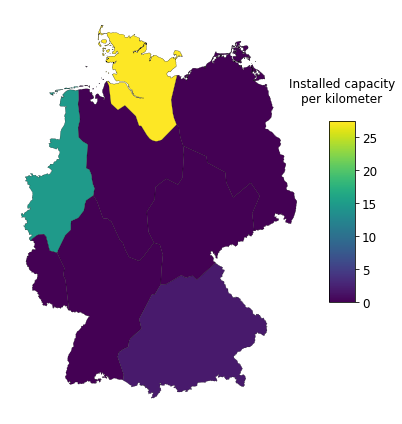

In [36]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (onshore)', locFilePath, 'index', perArea=False)

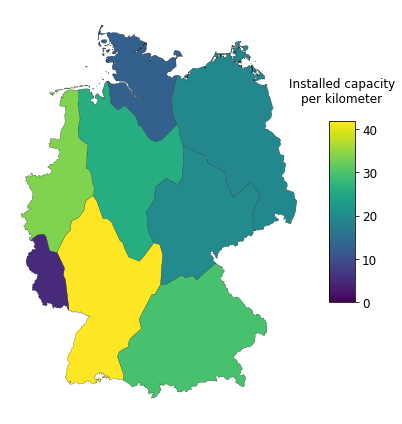

In [37]:
fig, ax = fn.plotLocationalColorMap(esM, 'PV', locFilePath, 'index', perArea=False)

Plot operation time series (either one or two dimensional)

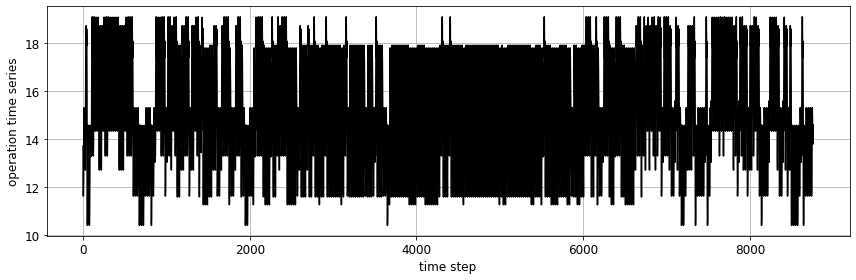

In [38]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'cluster_0')

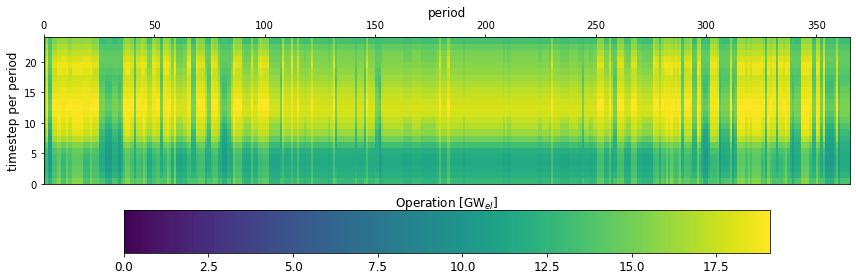

In [39]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'cluster_0')

### Conversion

Show optimization summary

In [40]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0   cluster_1  \
Component                Property  Unit                                      
Electrolyzer             TAC       [1e9 Euro/a]      0.0614655   0.0509074   
                         capacity  [GW$_{el}$]         0.70638    0.585044   
                         capexCap  [1e9 Euro/a]      0.0526358   0.0435944   
                         invest    [1e9 Euro]          0.35319    0.292522   
                         operation [GW$_{el}$*h/a]     2430.74     1835.28   
                         opexCap   [1e9 Euro/a]     0.00882975  0.00731305   
New CCGT plants (biogas) TAC       [1e9 Euro/a]      0.0574716    0.232827   
                         capacity  [GW$_{el}$]         0.70262     2.84643   
                         capexCap  [1e9 Euro/a]      0.0427166    0.173052   
                         invest    [1e9 Euro]         0.491834      1.9925   
                         operation [GW$_{el}$*h/a]     1236.16     4875.83   
                         opexCap   [1e9 Euro/a]       0.014755    0.059775   

                                                    cluster_2  cluster_3  \
Component                Property  Unit                                    
Electrolyzer             TAC       [1e9 Euro/a]      0.545151   0.128468   
                         capacity  [GW$_{el}$]        6.26505     1.4764   
                         capexCap  [1e9 Euro/a]      0.466838   0.110013   
                         invest    [1e9 Euro]         3.13252   0.738199   
                         operation [GW$_{el}$*h/a]    25503.2    5978.44   
                         opexCap   [1e9 Euro/a]     0.0783131   0.018455   
New CCGT plants (biogas) TAC       [1e9 Euro/a]      0.314601   0.135068   
                         capacity  [GW$_{el}$]        3.84617    1.65128   
                         capexCap  [1e9 Euro/a]      0.233832   0.100392   
                         invest    [1e9 Euro]         2.69232     1.1559   
                         operation [GW$_{el}$*h/a]    6863.73    2843.82   
                         opexCap   [1e9 Euro/a]     0.0807695  0.0346769   

                                                     cluster_4  cluster_5  \
Component                Property  Unit                                     
Electrolyzer             TAC       [1e9 Euro/a]       0.064736   0.178004   
                         capacity  [GW$_{el}$]        0.743966    2.04567   
                         capexCap  [1e9 Euro/a]      0.0554364   0.152433   
                         invest    [1e9 Euro]         0.371983    1.02284   
                         operation [GW$_{el}$*h/a]     2507.62    8210.61   
                         opexCap   [1e9 Euro/a]     0.00929957  0.0255709   
New CCGT plants (biogas) TAC       [1e9 Euro/a]       0.076445   0.086687   
                         capacity  [GW$_{el}$]        0.934579    1.05979   
                         capexCap  [1e9 Euro/a]      0.0568188  0.0644313   
                         invest    [1e9 Euro]         0.654205   0.741855   
                         operation [GW$_{el}$*h/a]     1684.95    1812.25   
                         opexCap   [1e9 Euro/a]      0.0196262  0.0222556   

                                                   cluster_6    cluster_7  
Component                Property  Unit                                    
Electrolyzer             TAC       [1e9 Euro/a]     0.996726   0.00210291  
                         capacity  [GW$_{el}$]       11.4547    0.0241673  
                         capexCap  [1e9 Euro/a]     0.853542   0.00180082  
                         invest    [1e9 Euro]        5.72734    0.0120837  
                         operation [GW$_{el}$*h/a]   52811.6       105.27  
                         opexCap   [1e9 Euro/a]     0.143183  0.000302092  
New CCGT plants (biogas) TAC       [1e9 Euro/a]            0   0.00920039  
                         capacity  [GW$_{el}$]             0     0.112479  
                         capexCap  [1e9 Euro/a]         

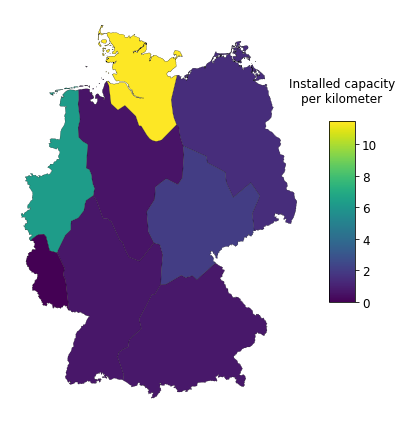

In [41]:
fig, ax = fn.plotLocationalColorMap(esM, 'Electrolyzer', locFilePath, 'index', perArea=False)

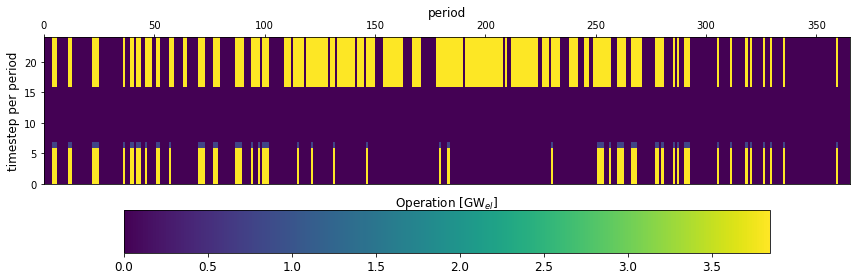

In [42]:
fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (biogas)', 'cluster_2')

### Storage

Show optimization summary

In [43]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

cluster_0  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]               0.167561   
                        capacity           [GW$_{el}$*h]                9.9722   
                        capexCap           [1e9 Euro/a]               0.147617   
                        invest             [1e9 Euro]                   1.5058   
                        operationCharge    [GW$_{el}$*h/a]             3451.22   
                        operationDischarge [GW$_{el}$*h/a]             3113.41   
                        opexCap            [1e9 Euro/a]              0.0199444   
Pumped hydro storage    TAC                [1e9 Euro/a]             0.00243637   
                        capacity           [GW$_{el}$*h]                15.924   
                        operationCharge    [GW$_{el}$*h/a]             7065.97   
                        operationDischarge [GW$_{el}$*h/a]             5471.72   
                        opexCap            [1e9 Euro/a]             0.00243637   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{biogas,LHV}$*h]           NaN   
                        capexCap           [1e9 Euro/a]                    NaN   
                        invest             [1e9 Euro]                      NaN   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]         NaN   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]         NaN   
                        opexCap            [1e9 Euro/a]                    NaN   
Salt caverns (hydrogen) TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{H_{2},LHV}$*h]            NaN   
                        capexCap           [1e9 Euro/a]                    NaN   
                        invest             [1e9 Euro]                      NaN   
                        operationCharge    [GW$_{H_{2},LHV}$*h/a]          NaN   
                        operationDischarge [GW$_{H_{2},LHV}$*h/a]          NaN   
                        opexCap            [1e9 Euro/a]                    NaN   

                                                                     cluster_1  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]               0.419777   
                        capacity           [GW$_{el}$*h]               24.9825   
                        capexCap           [1e9 Euro/a]               0.369812   
                        invest             [1e9 Euro]                  3.77236   
                        operationCharge    [GW$_{el}$*h/a]             8463.54   
                        operationDischarge [GW$_{el}$*h/a]             7635.68   
                        opexCap            [1e9 Euro/a]               0.049965   
Pumped hydro storage    TAC                [1e9 Euro/a]              0.0011859   
                        capacity           [GW$_{el}$*h]                 7.751   
                        operationCharge    [GW$_{el}$*h/a]             3963.84   
                        operationDischarge [GW$_{el}$*h/a]              3069.5   
                        opexCap            [1e9 Euro/a]              0.0011859   
Salt caverns (biogas)   TAC                [1e9 Euro/a]               0.029229   
                        capacity           [GW$_{biogas,LHV}$*h]       2156.63   
                        capexCap           [1e9 Euro/a]             0.00766271   
                        invest             [1e9 Euro]                0.0862651   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]     6215.24   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]     6215.24   
                        opexCap            [1e9 Euro/a]              0.0215663   
Salt caverns (hydrogen) TAC                [1e9 Eu

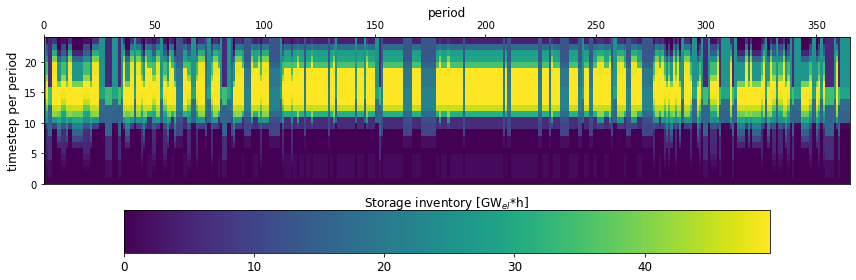

In [44]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'cluster_2', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

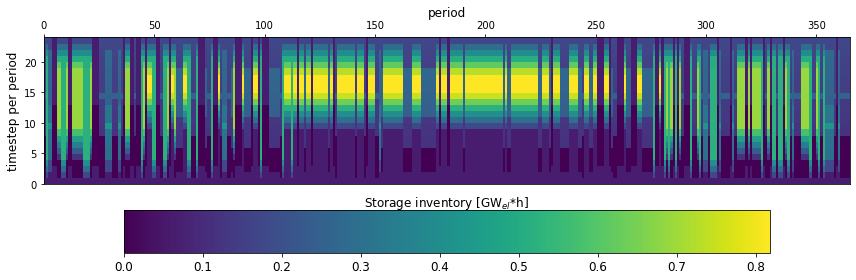

In [45]:
fig, ax = fn.plotOperationColorMap(esM, 'Pumped hydro storage', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

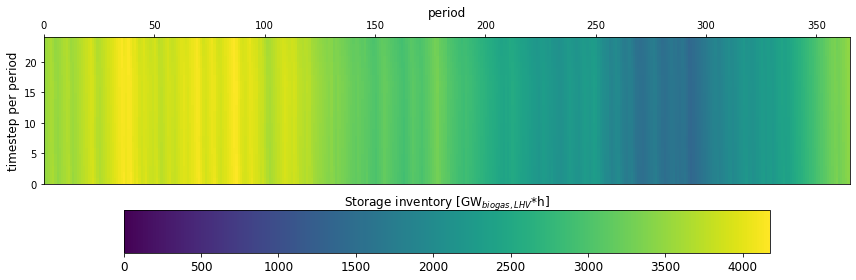

In [46]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (biogas)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

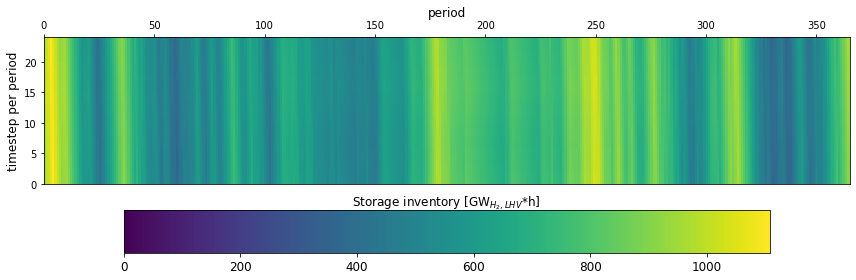

In [47]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

## Transmission

Show optimization summary

In [48]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc['Pipelines (hydrogen)']

cluster_0   cluster_1  \
Property     Unit                   LocationIn                           
TAC          [1e9 Euro/a]           cluster_0            0  0.00511966   
                                    cluster_1   0.00511966           0   
                                    cluster_2   0.00464921  0.00276739   
                                    cluster_3            0           0   
                                    cluster_4   0.00426177           0   
                                    cluster_6            0  0.00422026   
                                    cluster_7            0           0   
capacity     [GW$_{H_{2},LHV}$]     cluster_0          NaN     2.95872   
                                    cluster_1      2.95872         NaN   
                                    cluster_2   0.00172466  0.00142051   
                                    cluster_3          NaN           0   
                                    cluster_4      1.15049         NaN   
                                    cluster_6          NaN     5.05905   
                                    cluster_7            0         NaN   
capexIfBuilt [1e9 Euro/a]           cluster_0          NaN  0.00511966   
                                    cluster_1   0.00511966         NaN   
                                    cluster_2   0.00464921  0.00276739   
                                    cluster_3          NaN           0   
                                    cluster_4   0.00426177         NaN   
                                    cluster_6          NaN  0.00422026   
                                    cluster_7            0         NaN   
isBuilt      [-]                    cluster_0          NaN           1   
                                    cluster_1            1         NaN   
                                    cluster_2            1           1   
                                    cluster_3          NaN           0   
                                    cluster_4            1         NaN   
                                    cluster_6          NaN           1   
                                    cluster_7            0         NaN   
operation    [GW$_{H_{2},LHV}$*h/a] cluster_0          NaN     1688.68   
                                    cluster_1        24152         NaN   
                                    cluster_2      13.6766     7.72329   
                                    cluster_3          NaN           0   
                                    cluster_4      2.86461         NaN   
                                    cluster_6          NaN       38105   
                                    cluster_7            0         NaN   

                                                 cluster_2   cluster_3  \
Property     Unit                   LocationIn                           
TAC          [1e9 Euro/a]           cluster_0   0.00464921           0   
                                    cluster_1   0.00276739           0   
                                    cluster_2            0           0   
                                    cluster_3            0           0   
                                    cluster_4            0           0   
                                    cluster_6            0  0.00531338   
                                    cluster_7   0.00549326           0   
capacity     [GW$_{H_{2},LHV}$]     cluster_0   0.00172466         NaN   
                                    cluster_1   0.00142051           0   
                                    cluster_2          NaN         NaN   
                                    cluster_3          NaN         NaN   
                                    cluster_4          NaN         NaN   
                                    cluster_6          NaN    0.215968   
                                    cluster_7     0.165882         NaN   
capexIfBuilt [1e9 Euro/a]           cluster_0   0.00464921         NaN   
                                    cluster_1   0.00

Check that the shared capacity of the pipelines are not exceeded

In [49]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,2.958720,1.301089,NaN,1.892217,0.0,NaN,0.000000
cluster_1,2.958720,NaN,0.001421,0.000000,NaN,0.0,5.407007,NaN
cluster_2,1.301089,0.001421,NaN,NaN,NaN,NaN,NaN,0.305141
cluster_3,NaN,0.000000,NaN,NaN,NaN,0.0,0.215968,NaN
cluster_4,1.892217,NaN,NaN,NaN,NaN,0.0,NaN,NaN
cluster_5,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
cluster_6,NaN,5.407007,NaN,0.215968,NaN,NaN,NaN,NaN
cluster_7,0.000000,NaN,0.305141,NaN,NaN,NaN,NaN,NaN


Plot installed transmission capacities

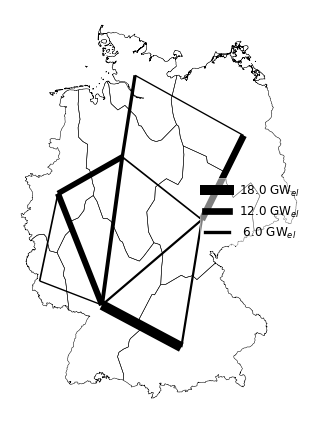

In [50]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

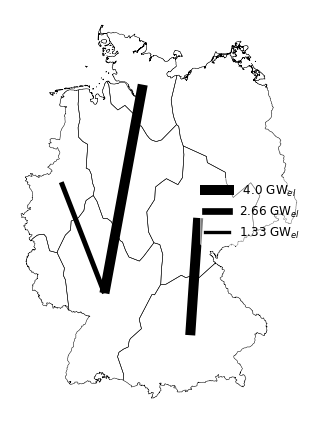

In [51]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

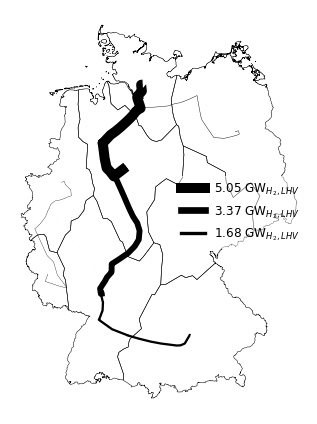

In [52]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='loc1', loc1='loc2',
                              fig=fig, ax=ax)

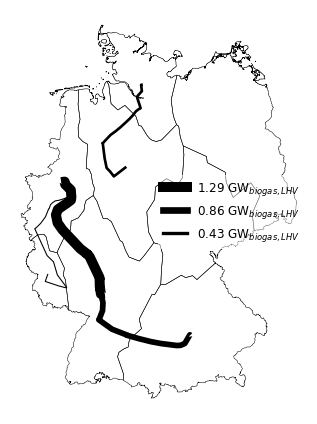

In [53]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='loc1', loc1='loc2',
                              fig=fig, ax=ax)

# Postprocessing: Determine robust pipeline design

In [54]:
# Import module expansion "robustPipelineSizing"
from FINE.expansionModules import robustPipelineSizing

In [55]:
# 1. Option to get the injection and withdrawal rates for the pipeline sizing (in kg/s)
rates = robustPipelineSizing.getInjectionWithdrawalRates(componentName='Pipelines (hydrogen)',esM=esM) # in GWh
# Convert GWh to kg/s: GWh * (kWh/GWh) * (kg/kWh) * (1/ timestepLengthInSeconds) with timestepLengthInSeconds
# being 3600 seconds for the present example
rates = rates * (10 ** 6) * (1/33.32) * (1/3600) 
rates.head()

,cluster_3,cluster_4,cluster_2,cluster_7,cluster_6,cluster_5,cluster_1,cluster_0
0,1.80045,9.591229,-1.397279,1.382901,-43.976052,0.0,17.509735,15.089016
1,1.80045,9.591229,-1.256247,1.241869,-43.976052,0.0,17.509735,15.089016
2,1.80045,9.591229,-1.256247,1.241869,-43.976052,0.0,17.509735,15.089016
3,1.80045,9.591229,-1.256247,1.241869,-43.976052,0.0,17.509735,15.089016
4,1.80045,9.591229,-1.268089,1.241869,-43.976052,0.0,17.521577,15.089016


In [56]:
# 2. Option to get the injection and withdrawal rates for the pipeline sizing (in kg/s)
op = esM.componentModelingDict[esM.componentNames['Pipelines (hydrogen)']].\
    getOptimalValues('operationVariablesOptimum')['values'].loc['Pipelines (hydrogen)']
rates = robustPipelineSizing.getInjectionWithdrawalRates(operationVariablesOptimumData=op) # in GWh
# Convert GWh to kg/s: GWh * (kWh/GWh) * (kg/kWh) * (1/ timestepLengthInSeconds) with timestepLengthInSeconds
# being 3600 seconds for the present example
rates = rates * (10 ** 6) * (1/33.32) * (1/3600) 
rates.head()

,cluster_0,cluster_1,cluster_2,cluster_4,cluster_5,cluster_7,cluster_3,cluster_6
0,15.089016,17.509735,-1.397279,9.591229,0.0,1.382901,1.80045,-43.976052
1,15.089016,17.509735,-1.256247,9.591229,0.0,1.241869,1.80045,-43.976052
2,15.089016,17.509735,-1.256247,9.591229,0.0,1.241869,1.80045,-43.976052
3,15.089016,17.509735,-1.256247,9.591229,0.0,1.241869,1.80045,-43.976052
4,15.089016,17.521577,-1.268089,9.591229,0.0,1.241869,1.80045,-43.976052


In [57]:
# Determine unique withdrawal and injection scenarios to save computation time
rates = rates.drop_duplicates()
rates.head()

,cluster_0,cluster_1,cluster_2,cluster_4,cluster_5,cluster_7,cluster_3,cluster_6
0,15.089016,17.509735,-1.397279,9.591229,0.0,1.382901,1.80045,-43.976052
1,15.089016,17.509735,-1.256247,9.591229,0.0,1.241869,1.80045,-43.976052
4,15.089016,17.521577,-1.268089,9.591229,0.0,1.241869,1.80045,-43.976052
5,15.089016,17.509735,-1.268089,9.591229,0.0,1.253711,1.80045,-43.976052
6,10.966815,24.883812,-1.241869,6.324975,0.0,1.241869,1.80045,-43.976052


In [58]:
# Get the lengths of the pipeline (in m)
lengths = robustPipelineSizing.getNetworkLengthsFromESM('Pipelines (hydrogen)', esM)
lengths = lengths * 1e3
lengths.head()

(cluster_3, cluster_6)    384000.0
(cluster_3, cluster_5)    292000.0
(cluster_3, cluster_1)    477000.0
(cluster_4, cluster_5)    688000.0
(cluster_4, cluster_0)    308000.0
dtype: float64

In [59]:
# Specify minimum and maximum pressure levels for all injection and withdrawal nodes (in bar)
p_min_nodes = {'cluster_5': 60, 'cluster_3': 50, 'cluster_7': 50, 'cluster_1': 60, 'cluster_6': 50,
               'cluster_4': 50, 'cluster_0': 50, 'cluster_2': 50}

p_max_nodes = {'cluster_5': 100, 'cluster_3': 100, 'cluster_7': 100, 'cluster_1': 90, 'cluster_6': 100,
               'cluster_4': 100, 'cluster_0': 100, 'cluster_2': 100}

In [60]:
# Specify the investment cost of the available diameter classes in €/m

# For single pipes
dic_diameter_costs = {0.1063: 37.51, 0.1307: 38.45, 0.1593: 39.64, 0.2065: 42.12,
                      0.2588: 45.26, 0.3063: 48.69, 0.3356: 51.07, 0.3844: 55.24,
                      0.432: 59.86, 0.4796: 64.98, 0.527: 70.56, 0.578: 76.61,
                      0.625: 82.99, 0.671: 89.95, 0.722: 97.38, 0.7686: 105.28,
                      0.814: 113.63, 0.864: 122.28, 0.915: 131.56, 0.96: 141.3,
                      1.011: 151.5, 1.058: 162.17, 1.104: 173.08, 1.155: 184.67,
                      1.249: 209.24, 1.342: 235.4, 1.444: 263.66, 1.536: 293.78}

# For parallel pipes
dic_candidateMergedDiam_costs={1.342: 235.4, 1.444: 263.66, 1.536: 293.78}

In [61]:
# Choose if a robust pipeline desin should be determined or the design should be optimized based on the
# given injection and withdrawal rates only
robust = True

### Determine design for simple network structure

Creating graph with respect to given distances
Original Network Graph:


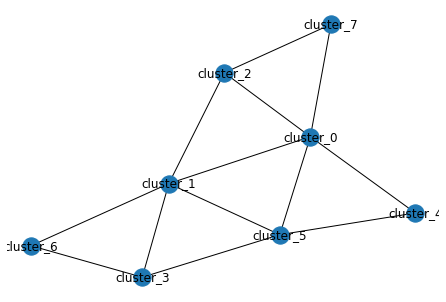

Creating a Steiner treee
Steiner tree:


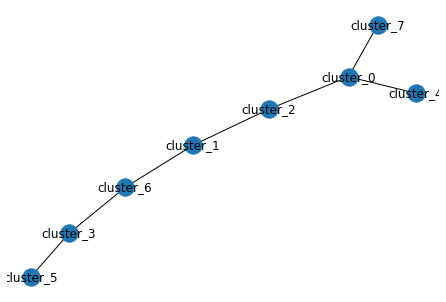

Compute robust scenario set for tree network (based on 56 node combinations). Threads: 7


Percentage simulated: 100%

Number of robust scenarios: 56
		(13.5158 sec)

Compute scenarios for each timestep. Number of timestep scenarios: 105. Threads: 7


Percentage simulated: 100%

		(15.9917 sec)

Compute equivalent single diameters for looped (parallel) pipes
Pressure drop coefficients for diameters with respect to robust scenarios
Determining optimal robust pipeline design under the consideration of pressure losses and robust scenarios
        0.04 seconds required to write file
        0.04 seconds required for presolve
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\there\AppData\Local\Temp\tmp2u0ylw60.glpk.raw --wglp C:\Users\there\AppData\Local\Temp\tmp3vvuq0vq.glpk.glp
 --cpxlp C:\Users\there\AppData\Local\Temp\tmpo87fi2n4.pyomo.lp
Reading problem data from 'C:\Users\there\AppData\Local\Temp\tmpo87fi2n4.pyomo.lp'...
C:\Users\there\AppData\Local\Temp\tmpo87fi2n4.pyomo.lp:10006: warning: lower bound of variable 'x1' redefined
C:\Users\there\AppData\Local\Temp\tmpo87fi2n4.pyomo.lp:10006: warning: upper bound of variable 'x1' redefined
400 rows, 666 columns, 7915 non-zeros
217 integer variables, all of which are

Percentage simulated: 100%

		(12.9476 sec)

Do postprocessing for each timestep scenarios. Number of scenarios: 105. Threads: 7


Percentage simulated: 100%

		(13.0150 sec)

Network with optimized diameters, looped pipes are indicated by two colored edges, Thicker edge means larger diameter


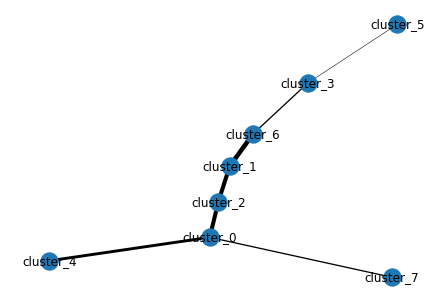

In [62]:
# Compute with 7 threads and simple network structure

dic_arc_optimalDiameters, dic_scen_PressLevels, dic_scen_MaxViolPress, dic_timeStep_PressLevels, \
    dic_timeStep_MaxViolPress, _ = robustPipelineSizing.determineDiscretePipelineDesign(
        robust=robust, injectionWithdrawalRates=rates,
        distances=lengths, dic_node_minPress=p_min_nodes, dic_node_maxPress=p_max_nodes, 
        dic_diameter_costs=dic_diameter_costs, dic_candidateMergedDiam_costs=dic_candidateMergedDiam_costs,
        threads=7)

Creating graph with respect to given distances
Original Network Graph:


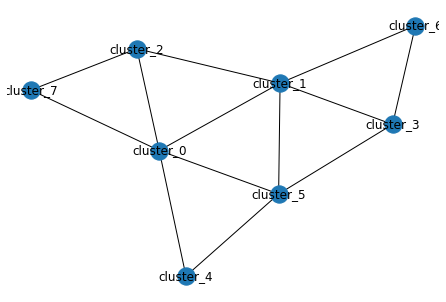

Creating a Steiner treee
Steiner tree:


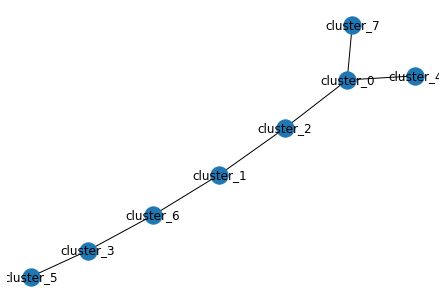

Compute robust scenario set for tree network (based on 56 node combinations). Threads: 2


Percentage simulated: 100%

Number of robust scenarios: 56
		(7.7526 sec)

Compute scenarios for each timestep. Number of timestep scenarios: 105. Threads: 2


Percentage simulated: 100%

		(9.1734 sec)

Compute equivalent single diameters for looped (parallel) pipes
Pressure drop coefficients for diameters with respect to robust scenarios
Determining optimal robust pipeline design under the consideration of pressure losses and robust scenarios
        0.03 seconds required to write file
        0.05 seconds required for presolve
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\there\AppData\Local\Temp\tmpqhnwt2u7.glpk.raw --wglp C:\Users\there\AppData\Local\Temp\tmpl7y4diuw.glpk.glp
 --cpxlp C:\Users\there\AppData\Local\Temp\tmp09ai0yxu.pyomo.lp
Reading problem data from 'C:\Users\there\AppData\Local\Temp\tmp09ai0yxu.pyomo.lp'...
C:\Users\there\AppData\Local\Temp\tmp09ai0yxu.pyomo.lp:10006: warning: lower bound of variable 'x1' redefined
C:\Users\there\AppData\Local\Temp\tmp09ai0yxu.pyomo.lp:10006: warning: upper bound of variable 'x1' redefined
400 rows, 666 columns, 7915 non-zeros
217 integer variables, all of which are 

Percentage simulated: 100%

		(6.5791 sec)

Do postprocessing for each timestep scenarios. Number of scenarios: 105. Threads: 2


Percentage simulated: 100%

		(7.0935 sec)

Network with optimized diameters, looped pipes are indicated by two colored edges, Thicker edge means larger diameter


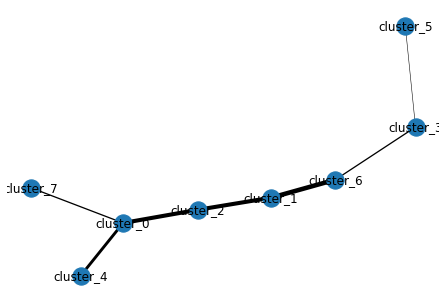

Finished Discrete Pipeline Optimization


In [63]:
# Compute with 2 threads and simple network structure

dic_arc_optimalDiameters, dic_scen_PressLevels, dic_scen_MaxViolPress, dic_timeStep_PressLevels, \
    dic_timeStep_MaxViolPress, _ = robustPipelineSizing.determineDiscretePipelineDesign(
        robust=robust, injectionWithdrawalRates=rates,
        distances=lengths, dic_node_minPress=p_min_nodes, dic_node_maxPress=p_max_nodes, 
        dic_diameter_costs=dic_diameter_costs, dic_candidateMergedDiam_costs=dic_candidateMergedDiam_costs,
        threads=2)

print("Finished Discrete Pipeline Optimization")

### Determine design for more complex network structure

In [64]:
# Redfine minimum and maximum pressure levels to reduce robust scenario computation time
p_min_nodes = {'cluster_5': 50, 'cluster_3': 50, 'cluster_7': 50, 'cluster_1': 50, 'cluster_6': 50,
               'cluster_4': 50, 'cluster_0': 50, 'cluster_2': 50}

p_max_nodes = {'cluster_5': 100, 'cluster_3': 100, 'cluster_7': 100, 'cluster_1': 100, 'cluster_6': 100,
               'cluster_4': 100, 'cluster_0': 100, 'cluster_2': 100}

Number of edges before segmentation: 13
Number of nodes before segmentation: 8
Number of edges after 1. segmentation: 144
Number of nodes after 1. segmentation: 136
Number of edges after 2. segmentation: 180
Number of nodes after 2. segmentation: 172
Minimum length [m]: 1247.6403125202671 Maximum length [m]: 34402.82497225889


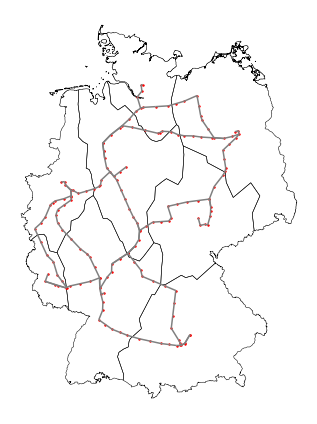

In [65]:
# Get more complex network structure
regColumn1 = 'loc1'
regColumn2 = 'loc2'

dic_node_minPress=p_min_nodes
dic_node_maxPress=p_max_nodes

maxPipeLength= 35 * 1e3
minPipeLength= 1 * 1e3

distances_new, dic_node_minPress_new, dic_node_maxPress_new, gdfNodes, gdfEdges = \
    robustPipelineSizing.getRefinedShapeFile(transFilePath, regColumn1, regColumn2, dic_node_minPress,
                                             dic_node_maxPress, minPipeLength, maxPipeLength)

fig, ax = fn.plotLocations(locFilePath, indexColumn='index') 

gdfEdges.plot(ax=ax, color='grey')
gdfNodes.plot(ax=ax, color='red', markersize=2)
ax.axis('off')

plt.show()

Creating graph with respect to given distances


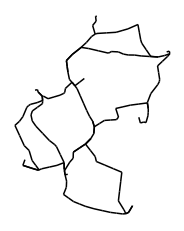

Creating a Steiner treee
Steiner tree:


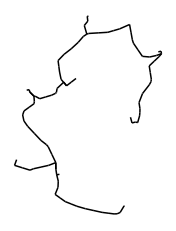

Compute robust scenario set for tree network (based on 10100 node combinations). Threads: 7
Reduced robust scenario set can be generated (pMax is equal at all nodes & pMin at exits is >= at inner and entry nodes).


Percentage simulated: 100%

Number of robust scenarios: 18
		(15.5744 sec)

Compute scenarios for each timestep. Number of timestep scenarios: 105. Threads: 7


Percentage simulated: 100%

		(19.9982 sec)

Compute equivalent single diameters for looped (parallel) pipes
Pressure drop coefficients for diameters with respect to robust scenarios
Determining optimal robust pipeline design under the consideration of pressure losses and robust scenarios
        0.23 seconds required to write file
        0.23 seconds required for presolve
Using license file C:\Users\there\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\there\AppData\Local\Temp\tmp07vxzu8i.pyomo.lp
Reading time = 0.08 seconds
x4919: 1901 rows, 4919 columns, 48675 nonzeros
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 1901 rows, 4919 columns and 48675 nonzeros
Model fingerprint: 0xe931bed8
Variable types: 1819 continuous, 3100 integer (3100 binary)
Coefficient statistics:
  Matrix range     [1e-04, 2e+07]
  Objective range  [5e+04, 2e+07]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 1e+00]
Presolve removed 1759 rows a

Percentage simulated: 100%

		(144.0653 sec)

Do postprocessing for each timestep scenarios. Number of scenarios: 105. Threads: 7


Percentage simulated: 100%

		(819.8905 sec)



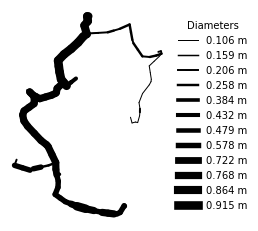

In [66]:
# Determine optimal pipeline design with seven threads
dic_arc_optimalDiameters, dic_scen_PressLevels, dic_scen_MaxViolPress, dic_timeStep_PressLevels, \
           dic_timeStep_MaxViolPress, gdfEdges = robustPipelineSizing.determineDiscretePipelineDesign(
        robust=robust, injectionWithdrawalRates=rates,
        distances=distances_new, dic_node_minPress=dic_node_minPress_new, dic_node_maxPress=dic_node_maxPress_new,
        dic_diameter_costs=dic_diameter_costs, dic_candidateMergedDiam_costs=dic_candidateMergedDiam_costs,
        gdfEdges=gdfEdges, regColumn1='nodeIn', regColumn2='nodeOut', threads=7, solver='gurobi')

### Plot scenario output

In [67]:
# Get regions shapefile as geopandas GeoDataFrame
gdf_regions = gpd.read_file(locFilePath)

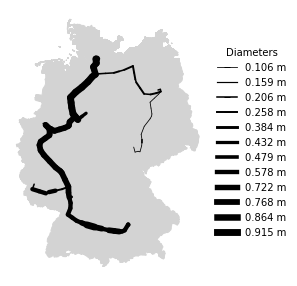

In [68]:
# Visualize pipeline diameters
fig, ax =robustPipelineSizing.plotOptimizedNetwork(gdfEdges, gdf_regions=gdf_regions, figsize=(5,5),
    line_scaling=0.8)

In [69]:
# Get a minimum and maximum pressure scenario
dic_timeStep_PressLevels = pd.DataFrame.from_dict(dic_scen_PressLevels)

scen_min = dic_timeStep_PressLevels.mean().min()
scen_min = dic_timeStep_PressLevels.loc[:,dic_timeStep_PressLevels.mean() == scen_min].iloc[:,0]
scen_max = dic_timeStep_PressLevels.mean().max()
scen_max = dic_timeStep_PressLevels.loc[:,dic_timeStep_PressLevels.mean() == scen_max].iloc[:,0]

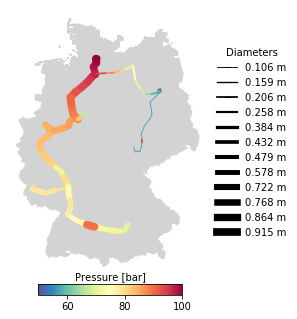

In [70]:
fig, ax =robustPipelineSizing.plotOptimizedNetwork(gdfEdges, gdf_regions=gdf_regions, figsize=(5,5),
    line_scaling=0.9, pressureLevels=scen_min)

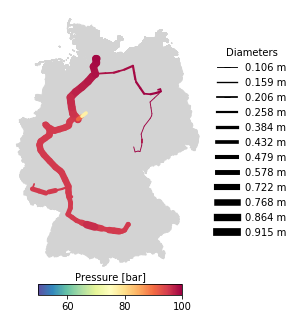

In [71]:
fig, ax =robustPipelineSizing.plotOptimizedNetwork(gdfEdges, gdf_regions=gdf_regions, figsize=(5,5),
    line_scaling=0.9, pressureLevels=scen_max)